In [3]:
!pip install torchvision

  Using cached torchvision-0.18.0-cp311-cp311-manylinux1_x86_64.whl.metadata (6.6 kB)
Using cached torchvision-0.18.0-cp311-cp311-manylinux1_x86_64.whl (7.0 MB)


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [47]:
epsilons = [0, .05, .1, .15, .2, .25, .3, .35, .4, .45, .5]
use_cuda=True
torch.manual_seed(42)

In [32]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/', train=True, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=512, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=512, shuffle=True)

print("CUDA Available: ",torch.cuda.is_available())
lr = 2e-4

# model = Net().to(device)
device = torch.device("cuda" if use_cuda and torch.cuda.is_available() else "cpu")
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr=lr)

# model.load_state_dict(torch.load(pretrained_model, map_location=device))
EPOCHS = 5
for epoch in range(EPOCHS):
    for idx, batch in tqdm(enumerate(train_loader)):
        model.train()
        X,y = batch
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optim.step()
        optim.zero_grad()

    test_correct = 0
    test_loss = 0
    total_samples = 0
    with torch.no_grad():
        for idx, batch in enumerate(test_loader):
            model.eval()
            test_X, test_y = batch
            test_X, test_y = test_X.to(device), test_y.to(device)
            total_samples += test_X.shape[0]
    
            test_pred = model(test_X)
            test_loss = loss_fn(test_pred, test_y)
            test_correct += (test_pred.argmax(dim=1) == test_y).sum().item()

    test_acc = test_correct / total_samples
    test_loss = test_loss / total_samples

    print(f"Test acc: {test_acc * 100:>.2f}% Test Loss: {test_loss}")
    
model.eval()

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
            ])),
        batch_size=1, shuffle=True)

CUDA Available:  True


118it [00:07, 15.54it/s]


Test acc: 98.78% Test Loss: 4.344612079876242e-06


118it [00:07, 15.68it/s]


Test acc: 98.78% Test Loss: 1.5360641327788471e-06


118it [00:07, 15.19it/s]


Test acc: 98.78% Test Loss: 6.944625511096092e-06


118it [00:07, 15.42it/s]


Test acc: 98.77% Test Loss: 4.102680577489082e-06


118it [00:07, 15.45it/s]


Test acc: 98.77% Test Loss: 2.916232460847823e-06


In [37]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign() # take deriv w.r.t data
    perturbed_image = image + epsilon*sign_data_grad # perturb img a little by eps
    perturbed_image = torch.clamp(perturbed_image, 0, 1) # all values above or below the range of [0,1] get clamped 🗜️
    return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    mean = torch.tensor(mean).to(device)
    std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [38]:
def test( model, device, test_loader, epsilon ):
    correct = 0
    adv_examples = []

    for data, target in test_loader:

        data, target = data.to(device), target.to(device)

        data.requires_grad = True

        
        output = model(data)
        init_pred = output.argmax(dim=1)

        if init_pred.item() != target.item():
            continue

        loss = F.nll_loss(output, target)

        model.zero_grad()

        loss.backward()

        data_grad = data.grad.data

        data_denorm = denorm(data) # just norm data

        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        output = model(perturbed_data_normalized)

        final_pred = output.max(1, keepdim=True)[1] 
        if final_pred.item() == target.item():
            correct += 1
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    final_acc = correct/float(len(test_loader))
    print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")

    return final_acc, adv_examples

In [46]:
accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0.0	Test Accuracy = 9877 / 10000 = 0.9877
Epsilon: 0.5	Test Accuracy = 9683 / 10000 = 0.9683
Epsilon: 1.0	Test Accuracy = 9282 / 10000 = 0.9282
Epsilon: 1.5	Test Accuracy = 8370 / 10000 = 0.837
Epsilon: 2.0	Test Accuracy = 6681 / 10000 = 0.6681
Epsilon: 2.5	Test Accuracy = 4140 / 10000 = 0.414
Epsilon: 3.0	Test Accuracy = 2073 / 10000 = 0.2073
Epsilon: 3.5	Test Accuracy = 941 / 10000 = 0.0941
Epsilon: 4.0	Test Accuracy = 416 / 10000 = 0.0416
Epsilon: 4.5	Test Accuracy = 237 / 10000 = 0.0237
Epsilon: 5.0	Test Accuracy = 192 / 10000 = 0.0192


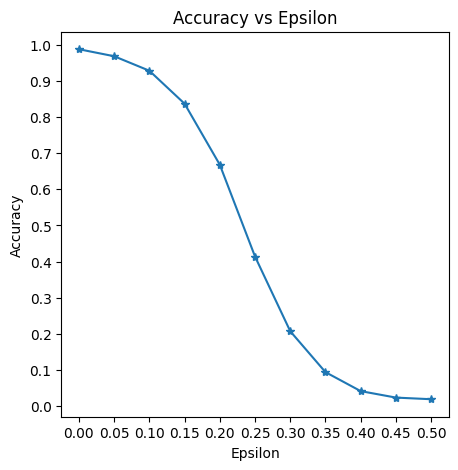

In [49]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .55, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()


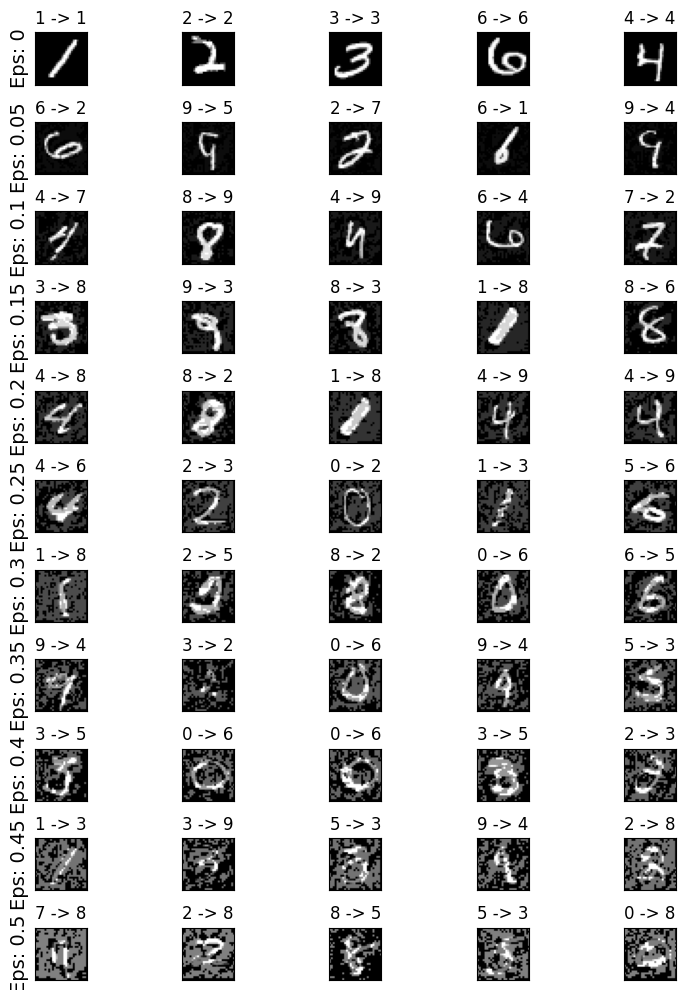

In [50]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()